In [3]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

In [4]:
# Load the dataset
df_data_daily_activity = pd.read_csv('data_daily_activity.csv')
df_data_daily_activity.head()
# Display the first few rows of the dataframe
print(df_data_daily_activity.head())

# Check for any missing values and data types
print(df_data_daily_activity.info())

# Value counts for 'platform'
print(df_data_daily_activity['platform'].value_counts())  # Distribution of users by platform

  activity_date   user_id platform
0    01/03/2024  303384.0      Ios
1    01/03/2024  309284.0      ios
2    01/03/2024  273596.0  android
3    01/03/2024  281336.0  android
4    01/03/2024  279453.0      Ios
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757784 entries, 0 to 757783
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   activity_date  757784 non-null  object 
 1   user_id        757784 non-null  float64
 2   platform       757784 non-null  object 
dtypes: float64(1), object(2)
memory usage: 17.3+ MB
None
platform
android    441472
Android    235095
ios         52987
Ios         28230
Name: count, dtype: int64


There is no null values.
There are inconsistencies in the data that need to be addressed:

* The platform names are repeated due to differences in capitalization (e.g., "iOS" vs. "ios"). We will standardize them 
  by converting all platform names to lowercase.
* The activity_date column has an incorrect data type. We will convert it to a proper datetime format to ensure consistency.
* The user_id column has incorrect data type. we will be converting it to a proper int format to ensure consistency.
* The platform column has incorrect data type . we will be converting it to a proper string format to ensure consistency.

In [5]:
# Before analyzing the data, we need to clean and preprocess it. 
# This includes formatting dates, handling duplicates, and standardizing platform names.
# Convert 'activity_date' to a DateTime format
df_data_daily_activity['activity_date'] = pd.to_datetime(df_data_daily_activity['activity_date'], format='%d/%m/%Y')

# Standardize the 'platform' column to have consistent cases
df_data_daily_activity['platform'] = df_data_daily_activity['platform'].str.lower()

# Standardize the 'platform' column to have consistent capitalization
df_data_daily_activity['user_id'] = df_data_daily_activity['user_id'].astype(int)

# Convert 'platform' column from object to string
df_data_daily_activity['platform'] = df_data_daily_activity['platform'].astype(str)

# Check for any missing values and data types
print(df_data_daily_activity.info())

# Value counts for 'platform'
print(df_data_daily_activity['platform'].value_counts()) # Distribution of users by platform

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757784 entries, 0 to 757783
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   activity_date  757784 non-null  datetime64[ns]
 1   user_id        757784 non-null  int32         
 2   platform       757784 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 14.5+ MB
None
platform
android    676567
ios         81217
Name: count, dtype: int64


In [6]:

# Descriptive statistics for 'user_id'
print('The total number of users(players):',df_data_daily_activity['user_id'].nunique())  # Number of unique users


The total number of users(players): 28230


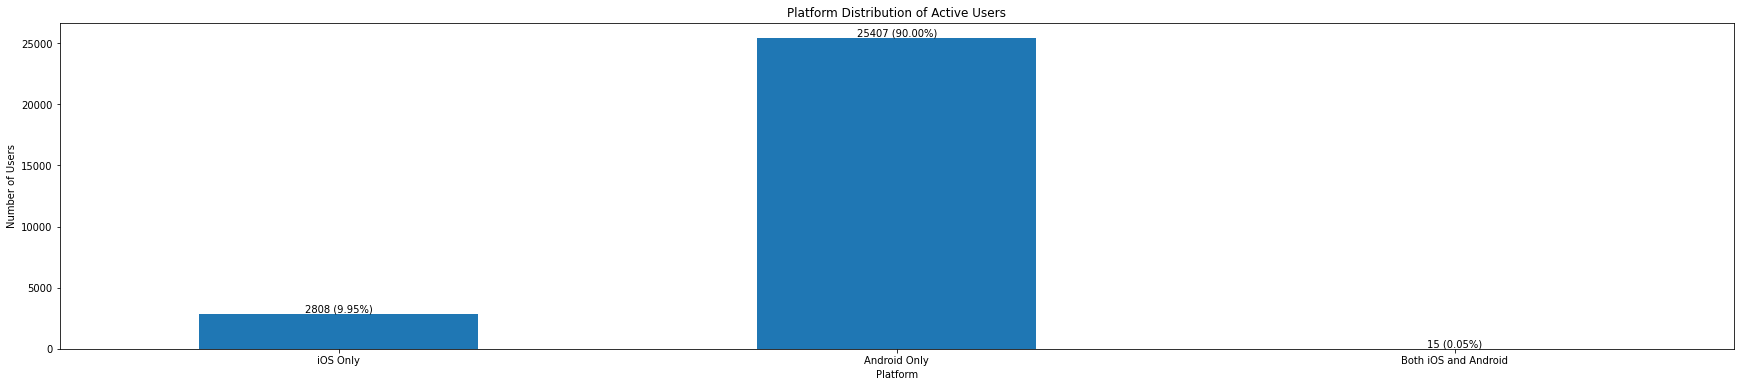

In [7]:
# Identify users using each platform and those using both
ios_users = df_data_daily_activity[df_data_daily_activity['platform'] == 'ios']['user_id'].unique()
android_users = df_data_daily_activity[df_data_daily_activity['platform']== 'android']['user_id'].unique()

# Users using both platforms
both_platform_users = list(set(ios_users) & set(android_users))

# Users only on iOS or Android
only_ios_users = list(set(ios_users) - set(both_platform_users))
only_android_users = list(set(android_users) - set(both_platform_users))

# Calculate counts and percentages
total_users = len(set(df_data_daily_activity['user_id']))
count_ios_only = len(only_ios_users)
count_android_only = len(only_android_users)
count_both = len(both_platform_users)

percentage_ios_only = (count_ios_only / total_users) * 100
percentage_android_only = (count_android_only / total_users) * 100
percentage_both = (count_both / total_users) * 100

# Create a DataFrame for plotting
platform_distribution = pd.DataFrame({
    'Platform': ['iOS Only', 'Android Only', 'Both iOS and Android'],
    'Count': [count_ios_only, count_android_only, count_both],
    'Percentage': [percentage_ios_only, percentage_android_only, percentage_both]
})

# Plot the distribution
ax = platform_distribution.plot(kind='bar', x='Platform', y='Count', legend=False,
                                title='Platform Distribution of Active Users', xlabel='Platform', ylabel='Number of Users', figsize=(30,6))

# Add data labels with both count and percentage
for i, row in platform_distribution.iterrows():
    count = row['Count']
    percentage = row['Percentage']
    ax.text(i, count + 5, f'{count} ({percentage:.2f}%)', ha='center', va='bottom')

plt.xticks(rotation=0)  # Ensure platform labels are horizontal
plt.show()

Insights:

* Out of the total users, 90% exclusively use Android. Specifically, 25407 users are on Android only.
* 10% of the users use iOS. This amounts to 2808 users.
* A very small fraction, 0.05%, use both Android and iOS. This is 15 users.
* In total, there are 28230 users in the dataset.

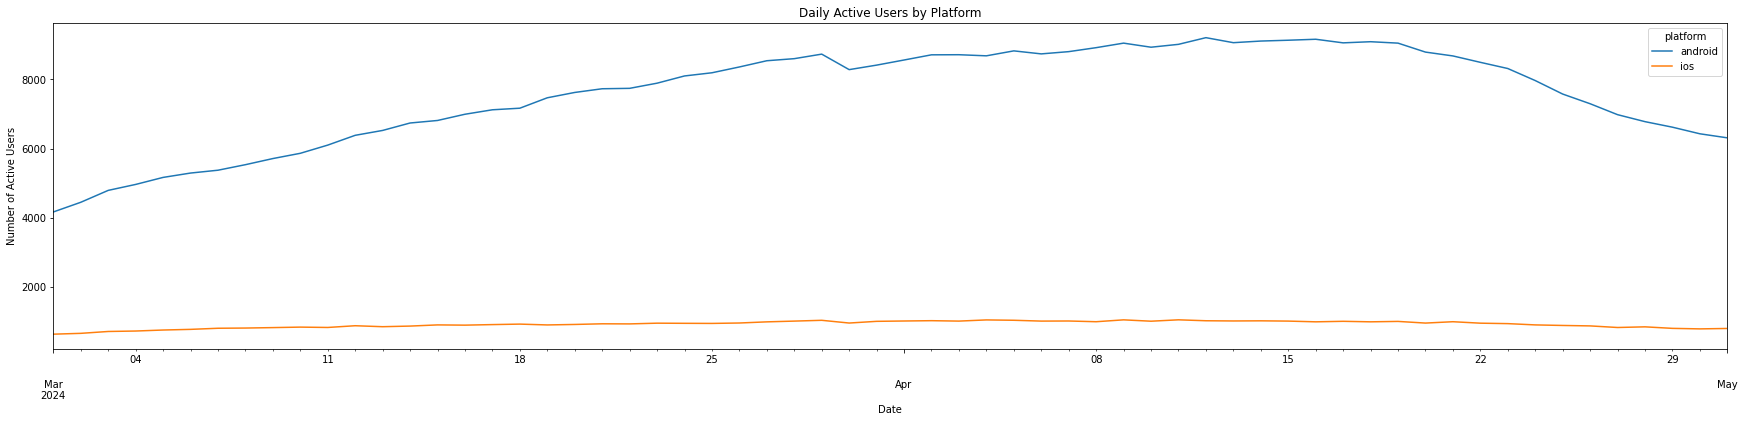

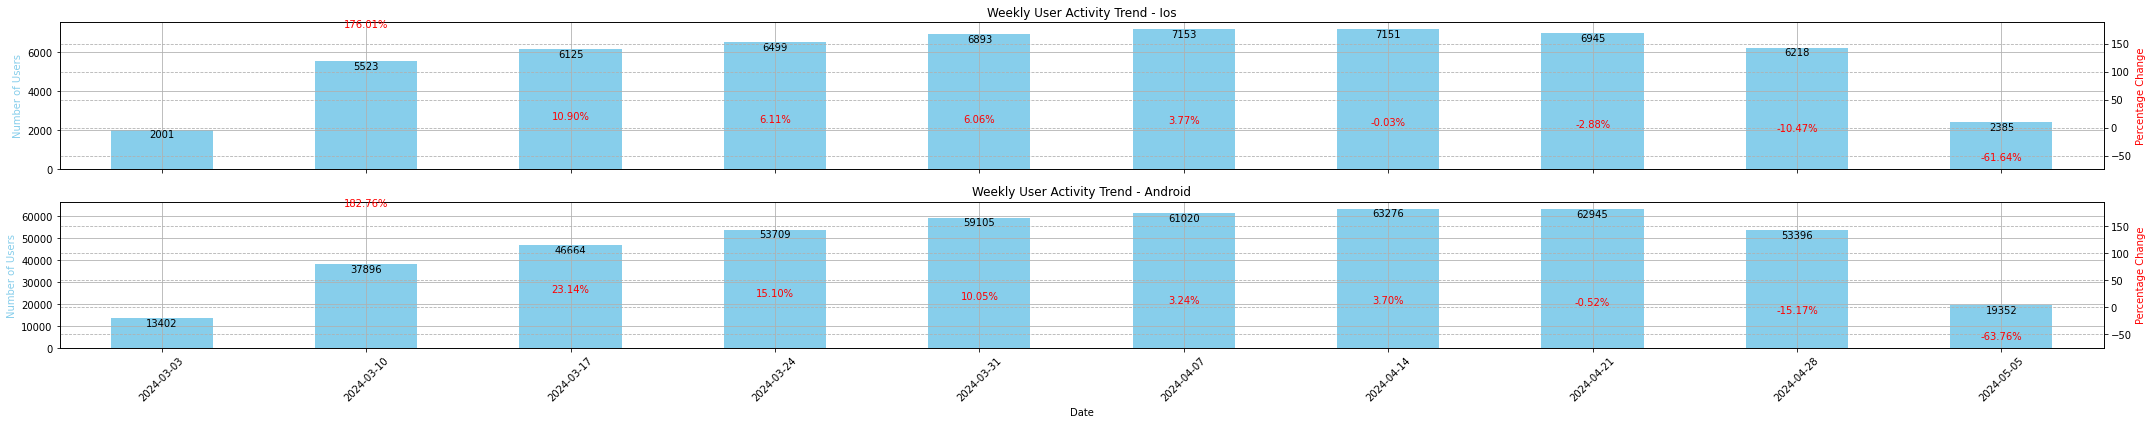

In [8]:

# Calculate daily active users by platform
daily_active_users_platform = df_data_daily_activity.groupby(['activity_date', 'platform'])['user_id'].nunique().unstack()

# Plot the trend
daily_active_users_platform.plot(kind='line', title='Daily Active Users by Platform', xlabel='Date', ylabel='Number of Active Users',
                                 figsize=(30, 6))

# Separate the data by platform
platforms = df_data_daily_activity['platform'].unique()

# Create a figure with subplots for each platform
fig, axes = plt.subplots(nrows=len(platforms), ncols=1, figsize=(30, 6), sharex=True)

for idx, platform in enumerate(platforms):
    # Filter data for the current platform
    platform_data = df_data_daily_activity[df_data_daily_activity['platform'] == platform]
    
    # Calculate the count of unique users per day
    daily_user_activity = platform_data.groupby('activity_date')['user_id'].nunique()
    
    # Resample to weekly data (starting on Monday)
    weekly_user_activity = daily_user_activity.resample('W').sum()
    
    # Calculate the percentage change week-over-week
    percentage_change = weekly_user_activity.pct_change() * 100
    
    # Create a DataFrame for plotting
    weekly_data = pd.DataFrame({
        'Number of Users': weekly_user_activity,
        'Percentage Change': percentage_change
    })
    
    # Plot the data
    ax1 = axes[idx]
    ax2 = ax1.twinx() if len(platforms) > 1 else ax1
    
    # Plot the bars for weekly user activity
    weekly_data['Number of Users'].plot(kind='bar', ax=ax1, color='skyblue', label='Weekly Active Users')
    
    # Plot the line for percentage change
    ax2.plot(weekly_data.index, weekly_data['Percentage Change'], color='orange', marker='o', label='Percentage Change', linestyle='--')
    
    # Add data labels to the bar chart
    for i in range(len(weekly_data)):
        count = weekly_data['Number of Users'].iloc[i]
        percentage = weekly_data['Percentage Change'].iloc[i]
        ax1.text(i, count + 10, f'{count}', ha='center', va='top')
        if not pd.isna(percentage):
            ax2.text(i, percentage, f'{percentage:.2f}%', color='red', ha='center', va='bottom')
    
    # Add titles, labels, and legends
    ax1.set_title(f'Weekly User Activity Trend - {platform.capitalize()}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Users', color='skyblue')
    ax2.set_ylabel('Percentage Change', color='red')
    ax1.grid(True)
    ax2.grid(True, linestyle='--')
    
    # Set x-ticks to show dates
    ax1.set_xticks(range(len(weekly_data)))
    ax1.set_xticklabels(weekly_data.index.strftime('%Y-%m-%d'), rotation=45)
  

plt.tight_layout()
plt.show()


Insight: 
* There has been a consistent decline in daily active users since the third week of April for Android users
* There has been a consistent decline in daily active users since the second week of April for iOS users.

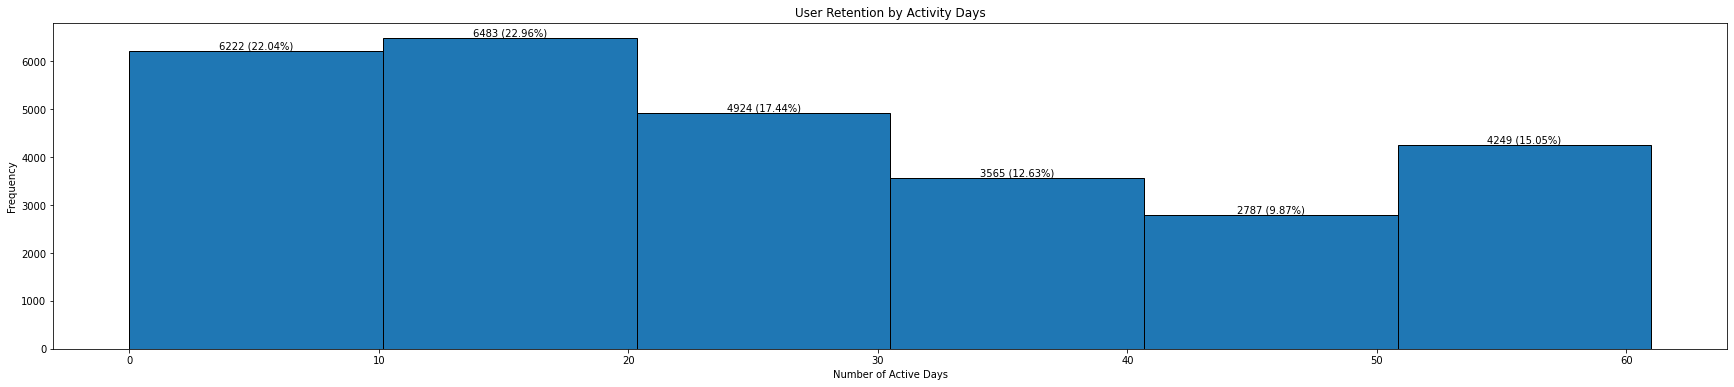

In [9]:
# Group by 'user_id' to find the first and last activity dates for each user
user_activity_span = df_data_daily_activity.groupby('user_id')['activity_date'].agg(['min', 'max']).reset_index()

# Calculate the days between the first and last activity
user_activity_span['activity_days'] = (user_activity_span['max'] - user_activity_span['min']).dt.days

# Plotting user retention over different days of activity
fig, ax = plt.subplots(figsize=(30, 6))

# Plot the histogram
n_bins = 6
counts, bin_edges, patches = ax.hist(user_activity_span['activity_days'], bins=n_bins, edgecolor='black')

# Calculate total number of data points for percentages
total_count = len(user_activity_span['activity_days'])

# Add data labels with count and percentage
for count, edge in zip(counts, bin_edges[:-1]):
    percentage = (count / total_count) * 100
    ax.text(edge + (bin_edges[1] - bin_edges[0]) / 2, count + 0.5, f'{int(count)} ({percentage:.2f}%)',
            ha='center', va='bottom')

# Add titles and labels
ax.set_title('User Retention by Activity Days')
ax.set_xlabel('Number of Active Days')
ax.set_ylabel('Frequency')

plt.show()



Insight: User Retention

* 22.04% of users were retained for the first 10 days, totaling 6222 users.
* 22.96% of users were retained for 10 to 20 days, totaling 6483 users.
* 17.44% of users were retained for 20 to 30 days, totaling 4924 users.
* 12.63% of users were retained for 30 to 40 days, totaling 3565 users.
* 9.87% of users were retained for 40 to 50 days, totaling 2787 users.
* 15.05% of users were retained for 50 to 60 days, totaling 4249 users.

In [10]:
#Creating a function to calculate mode
def mode_custom(series):
    return series.mode().iloc[0]

In [11]:
#Creating new features and dataframe for further analysis.
# Calculate the total number of days a user was active
player_activity_counts = df_data_daily_activity.groupby('user_id').agg(
    acquisition_date=('activity_date', 'min'),
    last_active_date=('activity_date', 'max'),
    platform=('platform',mode_custom),
    total_active_days=('activity_date', 'nunique'),  # Total unique active days
).reset_index()

# Calculate the number of days between first and last activity
player_activity_counts['total_activity_days'] = ((player_activity_counts['last_active_date'] - player_activity_counts['acquisition_date']).dt.days) + 1

#change the data type
player_activity_counts['total_active_days']=player_activity_counts['total_active_days'].astype(int)
player_activity_counts['total_activity_days']=player_activity_counts['total_activity_days'].astype(int)

# Sort players by their user_id, reset index
df_daily_activities = player_activity_counts.sort_values(by='user_id', ascending=True).reset_index(drop=True)
df_daily_activities.head()






,user_id,acquisition_date,last_active_date,platform,total_active_days,total_activity_days
0,272069,2024-03-01,2024-05-01,ios,53,62
1,272070,2024-03-16,2024-05-01,android,47,47
2,272071,2024-04-01,2024-05-01,android,28,31
3,272073,2024-04-04,2024-04-30,android,22,27
4,272077,2024-03-23,2024-05-01,ios,36,40


* New features, including acquisition_date, last_active_date, total_active_days, and total_activity_days, were derived from the activity_date column
* df_daily_activities, a new DataFrame was created for further analysis

In [12]:
# Sace the file to local disk for further analysis.
df_daily_activities.to_csv('daily_activities.csv',index=False)